# Datorövning Nyquist

## Nyquists samplingssats

En bandbegränsad signal $x(t)$ med största frekvens $B$ Hz kan
återskapas exakt från sina sampel om den samplas med en frekvens
$f_s > 2B$. Detta kallas **Nyquistfrekvensen**: $f_N = 2B$.

Om $x(t)$ är bandbegränsad till $|f| < B$, så kan den återskapas från
sina sampel $x[n] = x(nT)$ (där $T = 1/f_s$) via: $$
x(t) = \sum_{n=-\infty}^{\infty} x[n] \cdot \text{sinc}\left( \frac{t - nT}{T} \right)
$$ där $\text{sinc}(u) = \frac{\sin(\pi u)}{\pi u}$.

## Poissons summationsformel

$$
   \sum_{n=-\infty}^{\infty} x(nT) e^{-i 2\pi f nT} = \frac{1}{T} \sum_{k=-\infty}^{\infty} X\left(f - \frac{k}{T}\right)
$$ Det vill säga: Fouriertransformen av en samplad signal (impulståg) är
en periodisering av spektrat $X(f)$ med period $f_s = 1/T$.
(Samplingsfrekvensen)

Om vi endast har ett **ändligt antal sampel**, motsvarar det en
**multiplikation med ett rektangelfönster i tiden**, vilket i
frekvensdomänen ger ytterligare en **faltning med sinc-funktionen** →
spektrum blir **utsmetat** (Dirichlet-kärnan i diskret tid).

------------------------------------------------------------------------

# **Python-övning**

In [31]:

import numpy as np
import matplotlib.pyplot as plt


Parametrar för "kontinuerlig" tidssignal och frekvensrepresentation. 

In [32]:

# -------------------------------
# 1. Parametrar
# -------------------------------
B = 5.0                     # Bandbredd i Hz
T_cont = 2.0                # Tidsintervall för "kontinuerlig" signal [-T_cont, T_cont]
N_cont = 8000               # Antal punkter för kontinuerlig approximation
t_cont = np.linspace(-T_cont, T_cont, N_cont)
dt_cont = t_cont[1] - t_cont[0]
df_cont = 1 / (N_cont * dt_cont)
f_cont = np.fft.fftfreq(N_cont, d=dt_cont)
f_cont = np.fft.fftshift(f_cont)


Skapa en slumpmässig bandbegränsad signal med amplitudspektrum 
$$ |X(f)| = \begin{cases} 1 - (f/B)^2 & |f| <B \\ 0 & |f|> B \end{cases} $$

In [33]:
# -------------------------------
# 2. Skapa bandbegränsad signal x(t)
# -------------------------------
# Amplitudspektrum: |X(f)| = 1 - (f/B)^2 för |f| < B, annars 0

def profil(f,B):
    return 1 - (np.abs(f) / B)**2

X_f = np.where(np.abs(f_cont) < B, profil(f_cont,B), 0)
# Observera X_f är den teoretiska profilen

# Slumpmässig fas (uniform [-π, π])
np.random.seed(42)
phase = np.random.uniform(-np.pi, np.pi, size=X_f.shape)
X_complex = X_f * np.exp(1j * phase) # Används inte senare

# Ta invers fouriertransform för att få x(t)
x_t = np.fft.ifft(np.fft.ifftshift(X_complex)) * N_cont * df_cont  # Skalning för kontinuerlig FT
x_t = np.real(x_t)  # Signalen bör vara reell
                    # fas slumpad symmetriskt, men vi tar realdelen för säkerhets skull

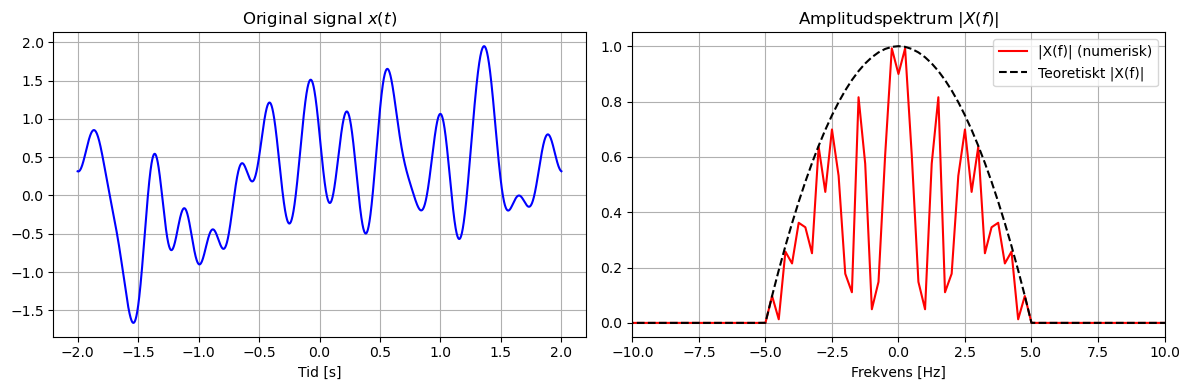

In [34]:

# -------------------------------
# 3. Plotta originalsignal och spektrum
# -------------------------------
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(t_cont, x_t, 'b', label='x(t)')
plt.title('Original signal $x(t)$')
plt.xlabel('Tid [s]')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(f_cont, np.abs(np.fft.fftshift(np.fft.fft(x_t)/N_cont/df_cont)), 'r-', label='|X(f)| (numerisk)')
plt.plot(f_cont, X_f, 'k--', label='Teoretiskt |X(f)|')
plt.title('Amplitudspektrum $|X(f)|$')
plt.xlabel('Frekvens [Hz]')
plt.xlim(-2*B, 2*B)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Uppgift
Skapa följande två hjälpfunktioner: `sha_train` och `sinc_interp`.

In [35]:
# -------------------------------
# 4. Hjälpfunktioner
# -------------------------------
def sha_train(t, T):
    """Impulståg (Dirac-kam) med period T """.
    return None

def sinc_interp(t, t_samples, x_samples, T):
    """Shannon-Whittaker interpolation"""
    return None


In [39]:

def do_nyquist_plot(fs): 
    T = 1.0 / fs
    # Sampel i samma intervall som t_cont
    t_samples = np.arange(-T_cont, T_cont + T, T)  # Samplingstider
    x_samples = np.interp(t_samples, t_cont, x_t)  # Exakta sampel från x(t)

    imp_train = sha_train(t_cont, T) # Impulståg 
    x_sampled_impulse = x_t * imp_train # Samplad signal som impulståg

    # Fouriertransform av samplad signal (numeriskt)
    X_sampled = np.fft.fftshift(np.fft.fft(x_sampled_impulse)) * dt_cont

    # Teoretiskt: periodisk repetition av X(f) med period fs
    X_replicated = np.zeros_like(f_cont)
    k_max = 5
    for k in range(-k_max, k_max+1):
        X_replicated += np.interp(f_cont - k*fs, f_cont, X_f, left=0, right=0)

    # Shannon-Whittaker interpolation
    x_recon = sinc_interp(t_cont, t_samples, x_samples, T)

    # -------------------------------
    # Plottar
    # -------------------------------
    plt.figure(figsize=(14, 8))

    # a) Tidssignal med sampel
    plt.subplot(2, 2, 1)
    plt.plot(t_cont, x_t, 'b', label='Original $x(t)$')
    plt.stem(t_samples, x_samples, linefmt='r-', markerfmt='ro', basefmt=" ", label='Sampel')
    plt.title(f'Tidssignal och sampel (fs = {fs:.1f} Hz, Nyquist = {2*B:.1f} Hz)')
    plt.xlabel('Tid [s]')
    plt.legend()
    plt.grid(True)

    # b) Spektrum: original + samplad (numeriskt) + teoretisk periodisk repetition
    plt.subplot(2, 2, 2)
    plt.plot(f_cont, np.abs(X_f), 'k--', label='Original $|X(f)|$')
    plt.plot(f_cont, np.abs(X_sampled)/np.max(np.abs(X_sampled)) * np.max(X_f), 'b', alpha=0.7, label='Samplad (numerisk)')
    plt.plot(f_cont, X_replicated, 'r:', label='Periodisk repetition')
    plt.xlim(-2*fs, 2*fs)
    plt.title('Spektrum: Original vs Samplad')
    plt.xlabel('Frekvens [Hz]')
    plt.legend()
    plt.grid(True)

    # c) Återskapad signal via Shannon-Whittaker
    plt.subplot(2, 2, 3)
    plt.plot(t_cont, x_t, 'b', label='Original $x(t)$')
    plt.plot(t_cont, x_recon, 'r--', label='Återskapad')
    plt.title('Shannon-Whittaker interpolation')
    plt.xlabel('Tid [s]')
    plt.legend()
    plt.grid(True)

    # d) Fel
    plt.subplot(2, 2, 4)
    error = np.abs(x_t - x_recon)
    plt.plot(t_cont, error, 'k')
    plt.title('Absolut fel i återskapning')
    plt.xlabel('Tid [s]')
    plt.grid(True)

    plt.tight_layout()
    plt.suptitle(f'Samplingsfrekvens: fs = {fs:.1f} Hz', fontsize=14, y=1.02)
    plt.show()


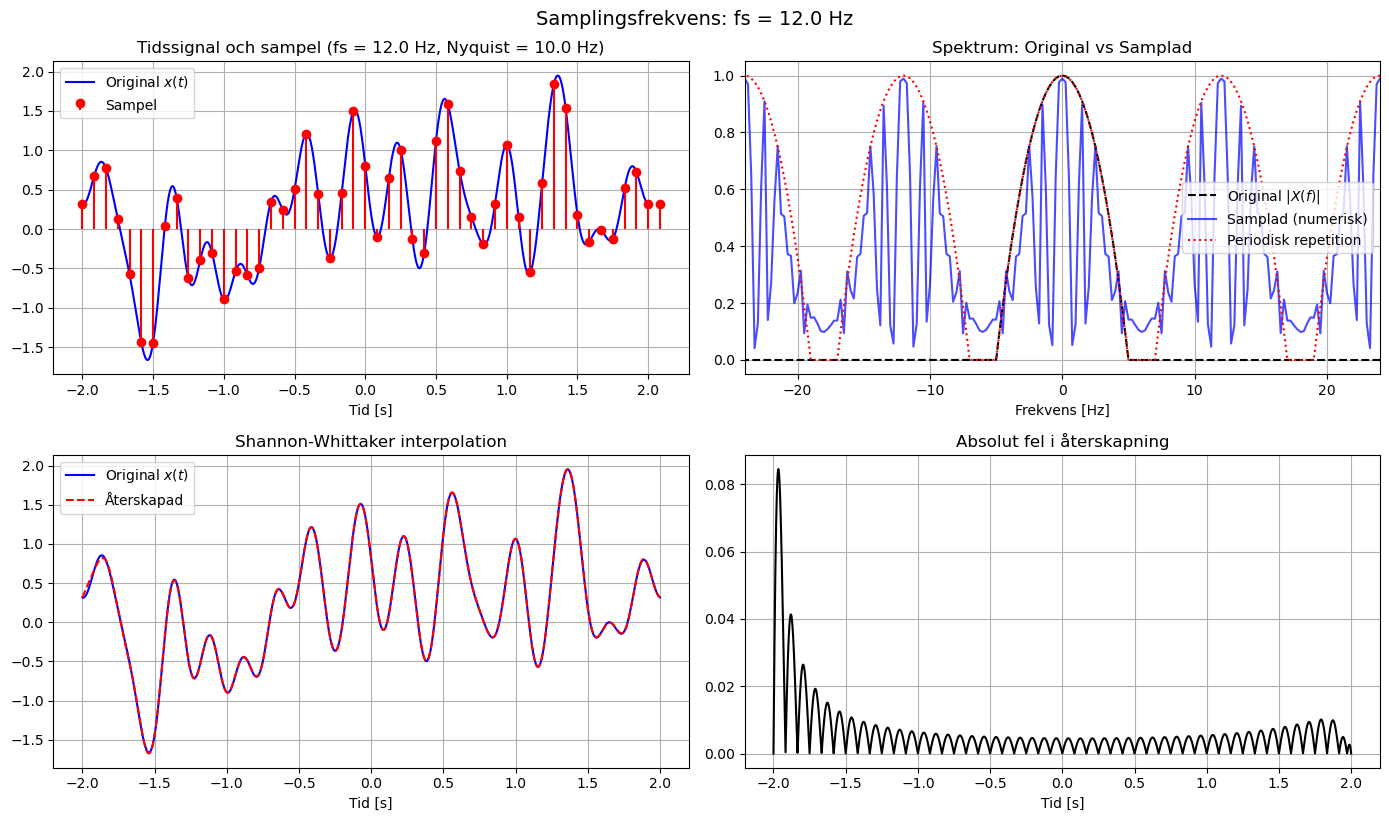

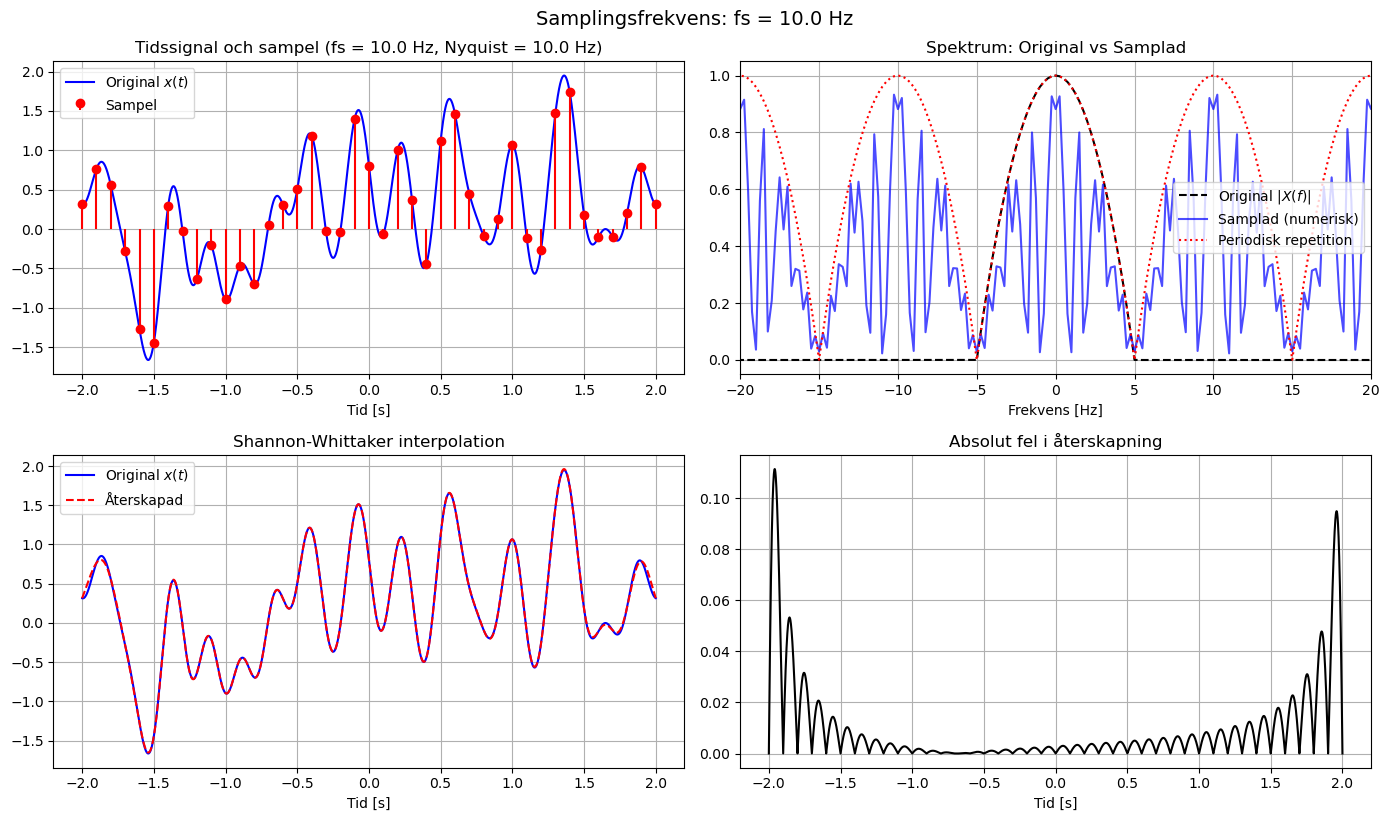

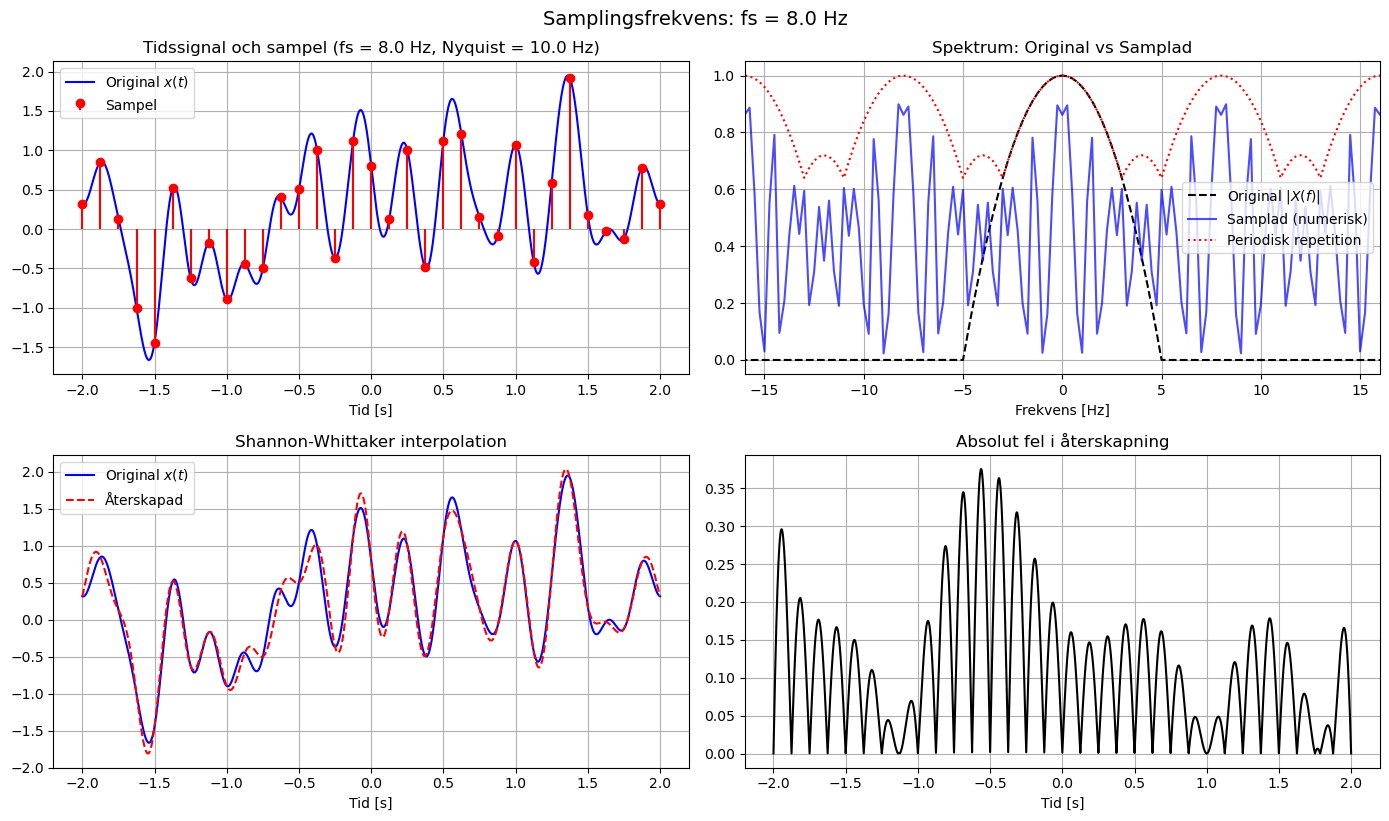

In [40]:

# -------------------------------
# 5. Loopa över olika samplingsfrekvenser
# -------------------------------
fs_list = [12.0, 10.0, 8.0] # Olika samplingsfrekvenser (fs > 2B = 10 => fs=12 OK, fs=10 kritisk, fs=8 undersampling)
for fs in fs_list:
    do_nyquist_plot(fs)


In [38]:
import numpy as np
